# CLUSTER 6 CLASSES

This notebook analyzes network traffic data using clustering techniques to identify patterns in network attacks. We'll explore two different approaches:
1. Standard K-means clustering with 6 clusters
2. Modified approach using DBSCAN with merged DoS/DDoS categories

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import time
from rich import print

In [2]:
df = pd.read_csv('/kaggle/input/dataset/train_sel_hclust.csv')

In [3]:

print("\nCategory distribution:")
print(df['category'].value_counts())

Category distribution:

category
DDoS        581986
DoS         284552
BENIGN      192732
MQTT        107607
RECON        52541
SPOOFING     16047
Name: count, dtype: int64

## 2. Data Preprocessing Functions

In [4]:
def balance_dataset(df, method='median_multiplier', multiplier=2):
    """
    Balance the dataset by downsampling majority classes.
    
    Parameters:
    - df: pandas DataFrame with 'category' column
    - method: str, approach for calculating threshold ('median_multiplier', 'mean_multiplier', 'quantile')
    - multiplier: float, multiplier for threshold calculation
    
    Returns:
    - balanced DataFrame
    """
    print(f"Original dataset size: {len(df)}")
    print("Original category distribution:")
    print(df['category'].value_counts())
    
    categories = df['category'].value_counts()
    
    # Calculate threshold based on method
    if method == 'median_multiplier':
        threshold = np.median(categories) * multiplier
    elif method == 'mean_multiplier':
        threshold = np.mean(categories) * multiplier
    elif method == 'quantile':
        threshold = categories.quantile(0.75)
    else:
        raise ValueError("Method must be 'median_multiplier', 'mean_multiplier', or 'quantile'")
    
    # Balance each category
    balanced_dfs = []
    for cat in categories.index:
        cat_df = df[df['category'] == cat]
        if len(cat_df) > threshold:
            cat_df = resample(cat_df, replace=False, n_samples=int(threshold), random_state=42)
        balanced_dfs.append(cat_df)
    
    balanced_df = pd.concat(balanced_dfs)
    
    print(f"\nBalanced dataset size: {len(balanced_df)}")
    print("Balanced category distribution:")
    print(balanced_df['category'].value_counts())
    
    return balanced_df.sample(frac=0.1, random_state=42)

def prepare_features(df):
    """
    Prepare features for clustering by dropping non-feature columns.
    """
    return df.drop(['category', 'attack', 'is_benign'], axis=1)

## 3. Clustering Functions

In [5]:
def calculate_clustering_metrics(X_scaled, clusters):
    """Calculate and print various clustering quality metrics."""
    if len(set(clusters)) > 1:
        metrics = {
            'Silhouette Score': silhouette_score(X_scaled, clusters),
            'Calinski-Harabasz Score': calinski_harabasz_score(X_scaled, clusters),
            'Davies-Bouldin Score': davies_bouldin_score(X_scaled, clusters)
        }
        
        print("\nClustering Quality Metrics:")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score:.3f}")
    
    return metrics

def analyze_cluster_distribution(df, clusters):
    """Analyze and print cluster size and category distribution."""
    print("\nCluster Size Distribution:")
    print(pd.Series(clusters).value_counts())
    
    print("\nCategory Distribution within Clusters:")
    print(pd.crosstab(clusters, df['category']))

def visualize_clusters(X_scaled, clusters, model=None, title_suffix=""):
    """
    Visualize clusters using PCA.
    
    Parameters:
    - X_scaled: scaled feature matrix
    - clusters: cluster assignments
    - model: fitted clustering model (optional, for showing centroids)
    - title_suffix: additional text for plot title
    """
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=clusters,
                         cmap='viridis',
                         alpha=0.6)
    
    # Add cluster centers for KMeans
    if hasattr(model, 'cluster_centers_'):
        centers_pca = pca.transform(model.cluster_centers_)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
                   c='red', marker='x', s=200, linewidths=3,
                   label='Cluster Centers')
        plt.legend()
    
    # Labels and title
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'2D Cluster Visualization using PCA {title_suffix}')
    plt.colorbar(scatter, label='Cluster')
    
    # Print variance explained
    total_var = sum(pca.explained_variance_ratio_)
    print(f"\nTotal explained variance by two components: {total_var:.2%}")
    print("\nIndividual explained variance ratios:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1}: {ratio:.2%}")
    
    plt.show()

## 4. Analysis: K-means Clustering

### Why K-means?

We start with K-means clustering because:
1. It's a simple and effective algorithm for our initial analysis
2. We have a reasonable assumption about the number of clusters (based on attack categories)
3. It works well with standardized numerical features

Original dataset size: 1235465

Original category distribution:

category
DDoS        581986
DoS         284552
BENIGN      192732
MQTT        107607
RECON        52541
SPOOFING     16047
Name: count, dtype: int64

Balanced dataset size: 953818

Balanced category distribution:

category
DDoS        300339
DoS         284552
BENIGN      192732
MQTT        107607
RECON        52541
SPOOFING     16047
Name: count, dtype: int64

Clustering Quality Metrics:

Silhouette Score: 0.407

Calinski-Harabasz Score: 10466.704

Davies-Bouldin Score: 1.353

Cluster Size Distribution:

3    32712
0    23020
2    18690
1    16077
4     4299
5      584
Name: count, dtype: int64

Category Distribution within Clusters:

category  BENIGN  DDoS   DoS  MQTT  RECON  SPOOFING
row_0                                              
0             85  5590  7064  5738   4540         3
1              0  9506  6570     0      1         0
2            242  9762  8168    51    135       332
3          17034  5369  6355  3030    414       510
4           1525    13    51  1966     73       671
5            463     0     0     2     71        48

Total explained variance by two components: 23.67%

Individual explained variance ratios:

PC1: 13.23%

PC2: 10.44%

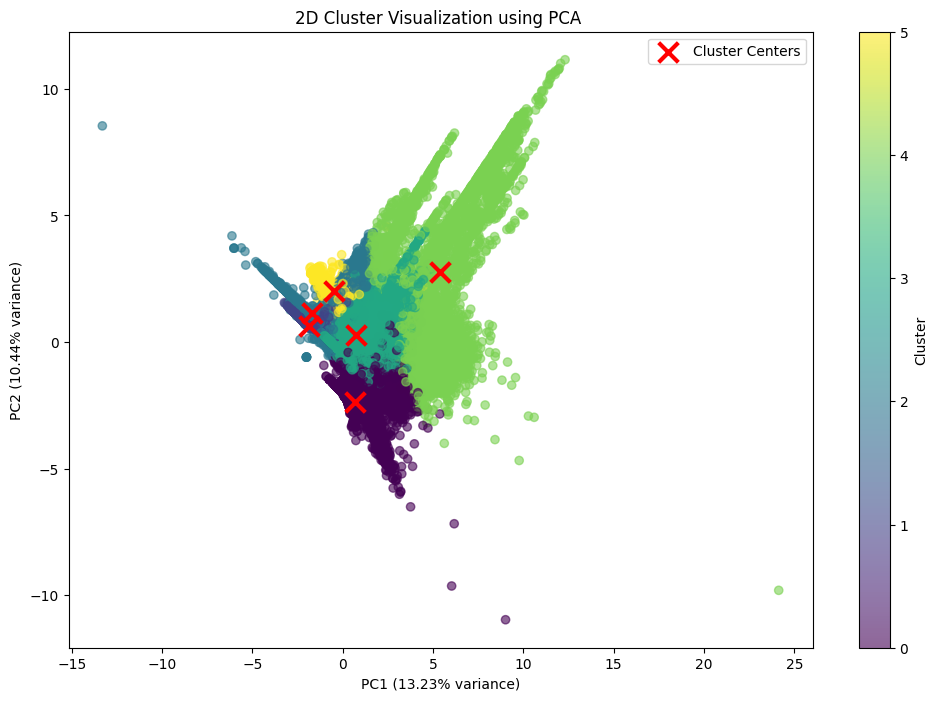

Clustering time: 97.87 seconds

In [6]:
# Balance the dataset
balanced_df = balance_dataset(df)

# Prepare and scale features
X = prepare_features(balanced_df)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
start_time = time.time()
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Calculate metrics and visualize
metrics = calculate_clustering_metrics(X_scaled, clusters)
analyze_cluster_distribution(balanced_df, clusters)
visualize_clusters(X_scaled, clusters, kmeans)

print(f"\nClustering time: {time.time() - start_time:.2f} seconds")

## 5. Modified Approach: DBSCAN with Merged Categories

### Why modify the approach?

Based on the K-means results, we observed:
1. Significant overlap between DDoS and DoS categories
2. Some clusters might not be spherical (a limitation of K-means)
3. StandardScaler might not be optimal for our feature distributions

Therefore, we implement these changes:
1. Merge DDoS and DoS into a single category
2. Use DBSCAN for non-spherical clusters
3. Switch to MinMaxScaler for better feature scaling

Original dataset size: 1235465

Original category distribution:

category
DOS_DDOS    866538
BENIGN      192732
MQTT        107607
RECON        52541
SPOOFING     16047
Name: count, dtype: int64

Balanced dataset size: 584141

Balanced category distribution:

category
DOS_DDOS    215214
BENIGN      192732
MQTT        107607
RECON        52541
SPOOFING     16047
Name: count, dtype: int64

Clustering Quality Metrics:

Silhouette Score: 0.381

Calinski-Harabasz Score: 4817.288

Davies-Bouldin Score: 1.341

Cluster Size Distribution:

0     31031
 2     12624
 3      6791
 1      6179
-1       657
 5       421
 4       334
 6       145
 7       111
 8        23
 10       21
 9        14
 12       14
 15       10
 13       10
 11       10
 14       10
 16        9
Name: count, dtype: int64

Category Distribution within Clusters:

category  BENIGN  DOS_DDOS   MQTT  RECON  SPOOFING
row_0                                             
-1           320        37    115    136        49
 0          9110      8506  10311   2448       656
 1             0      6179      0      0         0
 2          9159         0    103   2698       664
 3             0      6791      0      0         0
 4           213         0     35      0        86
 5           231         0     72      0       118
 6           145         0      0      0         0
 7           111         0      0      0         0
 8            23         0      0      0         0
 9            14         0      0      0         0
 10            5         0     13      0         3
 11            9         0      0      1         0
 12            2         0     11      0         1
 13           10         0      0      0         0
 14            0         0     10      0         0
 15            1         0      9      0         0
 16            9         0      0      0         0

Total explained variance by two components: 50.04%

Individual explained variance ratios:

PC1: 35.43%

PC2: 14.61%

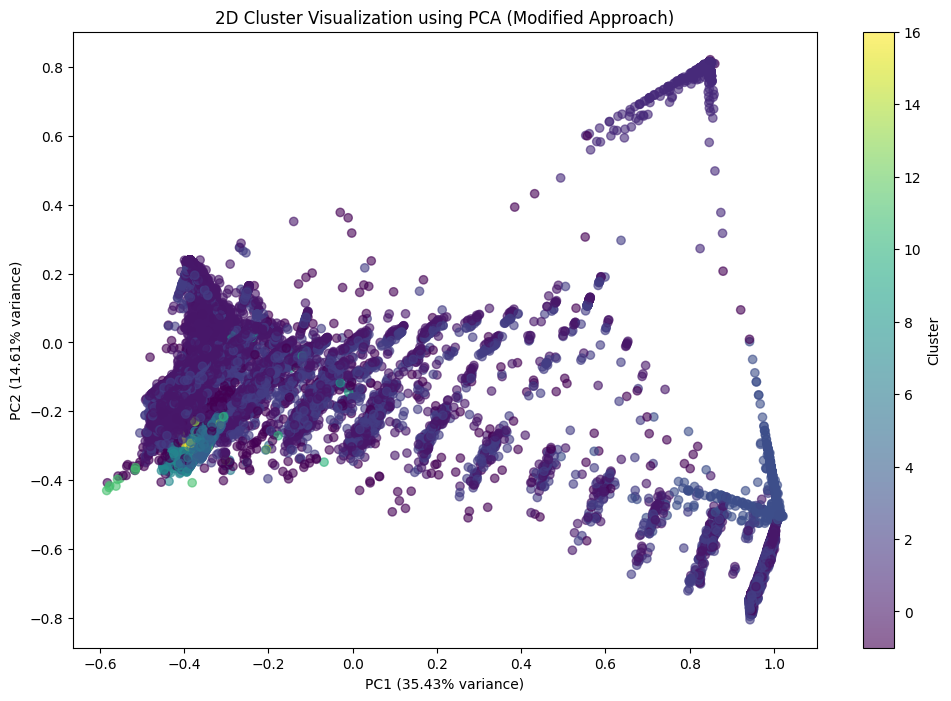

Clustering time: 48.57 seconds

In [7]:
# Modify categories
df_modified = df.copy()
df_modified['category'] = df_modified['category'].replace({
    'DDoS': 'DOS_DDOS',
    'DoS': 'DOS_DDOS'
})

# Balance the modified dataset
balanced_df_modified = balance_dataset(df_modified)

# Prepare and scale features
X_modified = prepare_features(balanced_df_modified)
scaler_modified = MinMaxScaler()
X_scaled_modified = scaler_modified.fit_transform(X_modified)

# Perform DBSCAN clustering
start_time = time.time()
dbscan = DBSCAN(eps=0.3, min_samples=10)
clusters_modified = dbscan.fit_predict(X_scaled_modified)

# Calculate metrics and visualize
metrics_modified = calculate_clustering_metrics(X_scaled_modified, clusters_modified)
analyze_cluster_distribution(balanced_df_modified, clusters_modified)
visualize_clusters(X_scaled_modified, clusters_modified, title_suffix="(Modified Approach)")

print(f"\nClustering time: {time.time() - start_time:.2f} seconds")